# Finetune ResNet50


With 1000 x 400 melspectrogram images without data augmentation

However, instead of resizing to 224x224, the images were resized to 448x448 instead


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
from PIL import Image

In [ ]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [ ]:
FINETUNED_MODEL = 'resnet50_448'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the precomputed tensors of the mel spectrogram images


In [ ]:
from ...datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the testing/evaluation function


In [8]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100

    return test_loss, test_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Check if current model is best performing using test_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)),
             test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 448x448, suitable for ResNet50
    transforms.Resize((448, 448)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


training: 100%|██████████| 395/395 [03:02<00:00,  2.16it/s, Loss=1.3081315755844116, Elapsed=192.7693s, ETA=0.0000s]  


Epoch 1 completed in 247.7185s
Train Loss: 1.511990672123583 - Train Accuracy: 40.63000850828074
Test Loss: 1.3948315538541236 - Test Accuracy: 47.17055797388207

Epoch 2/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.1670883893966675, Elapsed=190.5090s, ETA=0.0000s]  


Epoch 2 completed in 247.7723s
Train Loss: 1.3383875723126568 - Train Accuracy: 47.26053147074536
Test Loss: 1.3034262392255995 - Test Accuracy: 48.880094974277796

Epoch 3/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.2417662143707275, Elapsed=190.9732s, ETA=0.0000s]  


Epoch 3 completed in 245.6322s
Train Loss: 1.2981074173239213 - Train Accuracy: 49.10069451314826
Test Loss: 1.2866305835319287 - Test Accuracy: 49.94855559952513

Epoch 4/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.18it/s, Loss=1.4755823612213135, Elapsed=191.5958s, ETA=0.0000s]  


Epoch 4 completed in 247.9682s
Train Loss: 1.2680956457234636 - Train Accuracy: 50.45212608084846
Test Loss: 1.344940100053344 - Test Accuracy: 47.4000791452315

Epoch 5/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.1689013242721558, Elapsed=191.2510s, ETA=0.0000s]  


Epoch 5 completed in 246.6234s
Train Loss: 1.2494387427462808 - Train Accuracy: 51.255466075703914
Test Loss: 1.2641630148646807 - Test Accuracy: 50.11476058567471

Epoch 6/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.1997120380401611, Elapsed=190.9660s, ETA=0.0000s]  


Epoch 6 completed in 246.2553s
Train Loss: 1.2363601630247092 - Train Accuracy: 51.74024021053049
Test Loss: 1.240116678103052 - Test Accuracy: 51.78472497032054

Epoch 7/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.1484909057617188, Elapsed=191.0090s, ETA=0.0000s]  


Epoch 7 completed in 246.6751s
Train Loss: 1.2286862469926665 - Train Accuracy: 52.22699301529512
Test Loss: 1.2499920286313453 - Test Accuracy: 51.33359715077167

Epoch 8/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.1960322856903076, Elapsed=191.2555s, ETA=0.0000s]  


Epoch 8 completed in 246.7947s
Train Loss: 1.2176678950273538 - Train Accuracy: 52.87995409485744
Test Loss: 1.2412004302246402 - Test Accuracy: 51.57103284527107

Epoch 9/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.18it/s, Loss=1.110385775566101, Elapsed=191.6506s, ETA=0.0000s]   


Epoch 9 completed in 246.4851s
Train Loss: 1.2100569317612466 - Train Accuracy: 52.89182611448584
Test Loss: 1.216342740588718 - Test Accuracy: 53.090621290067276

Epoch 10/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.0773634910583496, Elapsed=191.3521s, ETA=0.0000s]  


Epoch 10 completed in 246.1935s
Train Loss: 1.2025043119358112 - Train Accuracy: 53.131245176992024
Test Loss: 1.2062651292242186 - Test Accuracy: 53.23308270676692

Epoch 11/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.20it/s, Loss=1.1681652069091797, Elapsed=190.5512s, ETA=0.0000s]  


Epoch 11 completed in 245.4612s
Train Loss: 1.1975281970410407 - Train Accuracy: 53.362749559745936
Test Loss: 1.207409422204952 - Test Accuracy: 53.64463791056588

Epoch 12/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.20it/s, Loss=1.1600645780563354, Elapsed=190.3229s, ETA=0.0000s]  


Epoch 12 completed in 245.0593s
Train Loss: 1.1895692167402823 - Train Accuracy: 53.83960901482023
Test Loss: 1.2112169337995125 - Test Accuracy: 52.932330827067666

Epoch 13/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.20it/s, Loss=1.219712257385254, Elapsed=190.3657s, ETA=0.0000s]   


Epoch 13 completed in 244.7825s
Train Loss: 1.184621475467199 - Train Accuracy: 54.11266546627357
Test Loss: 1.1913357852685331 - Test Accuracy: 53.45468935496637

Epoch 14/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.19it/s, Loss=1.2676738500595093, Elapsed=190.6711s, ETA=0.0000s]  


Epoch 14 completed in 245.4583s
Train Loss: 1.172851176956032 - Train Accuracy: 54.57369556184333
Test Loss: 1.1973901186326537 - Test Accuracy: 53.97704788286506

Epoch 15/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.0697611570358276, Elapsed=191.1115s, ETA=0.0000s]  


Epoch 15 completed in 246.0598s
Train Loss: 1.1729132881647424 - Train Accuracy: 54.66273570905638
Test Loss: 1.2035998304684956 - Test Accuracy: 53.58923624851602

Epoch 16/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.0483367443084717, Elapsed=191.2505s, ETA=0.0000s]  


Epoch 16 completed in 246.7702s
Train Loss: 1.1666631903829454 - Train Accuracy: 54.73198915688874
Test Loss: 1.1959220748959165 - Test Accuracy: 53.85833003561535

Epoch 17/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.20it/s, Loss=1.0092724561691284, Elapsed=190.4659s, ETA=0.0000s]  


Epoch 17 completed in 245.4889s
Train Loss: 1.1694843790199183 - Train Accuracy: 54.62909832010923
Test Loss: 1.1845234138797027 - Test Accuracy: 53.67629600316582

Epoch 18/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.1665221452713013, Elapsed=190.7782s, ETA=0.0000s]  


Epoch 18 completed in 245.4542s
Train Loss: 1.160463400581215 - Train Accuracy: 55.05055501691763
Test Loss: 1.1743156897901283 - Test Accuracy: 54.64978235061337

Epoch 19/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.20it/s, Loss=1.2601535320281982, Elapsed=190.3217s, ETA=0.0000s]  


Epoch 19 completed in 245.8735s
Train Loss: 1.1561342052266568 - Train Accuracy: 55.349334177565844
Test Loss: 1.1693953299763227 - Test Accuracy: 55.417491096161456

Epoch 20/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=0.9936787486076355, Elapsed=191.5314s, ETA=0.0000s]  


Epoch 20 completed in 246.8685s
Train Loss: 1.1544489348991007 - Train Accuracy: 55.41858762539821
Test Loss: 1.1575097206867102 - Test Accuracy: 55.46497823506134

Epoch 21/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.1444114446640015, Elapsed=190.7095s, ETA=0.0000s]  


Epoch 21 completed in 245.3647s
Train Loss: 1.1464737990234473 - Train Accuracy: 55.727260135736756
Test Loss: 1.1868828486914587 - Test Accuracy: 54.60229521171349

Epoch 22/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.20it/s, Loss=1.221591830253601, Elapsed=190.3563s, ETA=0.0000s]   


Epoch 22 completed in 245.9943s
Train Loss: 1.142609214631817 - Train Accuracy: 55.960743188428744
Test Loss: 1.2264891549794361 - Test Accuracy: 52.59200633161852

Epoch 23/25


training: 100%|██████████| 395/395 [02:59<00:00,  2.19it/s, Loss=1.0605340003967285, Elapsed=190.8195s, ETA=0.0000s]  


Epoch 23 completed in 245.5895s
Train Loss: 1.1455222837532624 - Train Accuracy: 55.93699914917193
Test Loss: 1.2135664977208533 - Test Accuracy: 53.70795409576573

Epoch 24/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.19it/s, Loss=1.0717103481292725, Elapsed=191.4808s, ETA=0.0000s]  


Epoch 24 completed in 245.8203s
Train Loss: 1.1453704720811 - Train Accuracy: 55.77870555412652
Test Loss: 1.1985523574280017 - Test Accuracy: 53.905817174515235

Epoch 25/25


training: 100%|██████████| 395/395 [03:00<00:00,  2.18it/s, Loss=1.1506905555725098, Elapsed=191.6822s, ETA=0.0000s]  


Epoch 25 completed in 246.7621s
Train Loss: 1.1344962328295165 - Train Accuracy: 56.09331407427926
Test Loss: 1.1642905967404145 - Test Accuracy: 54.84764542936288



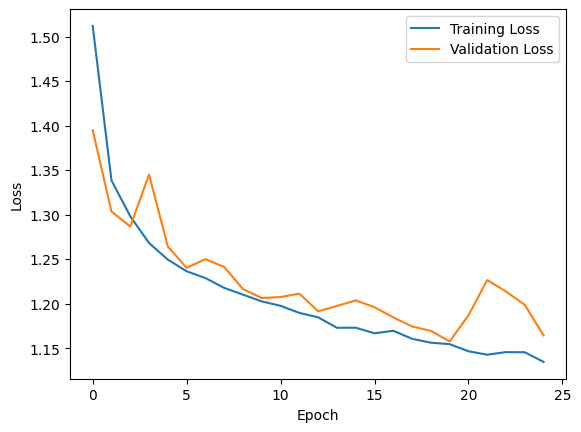

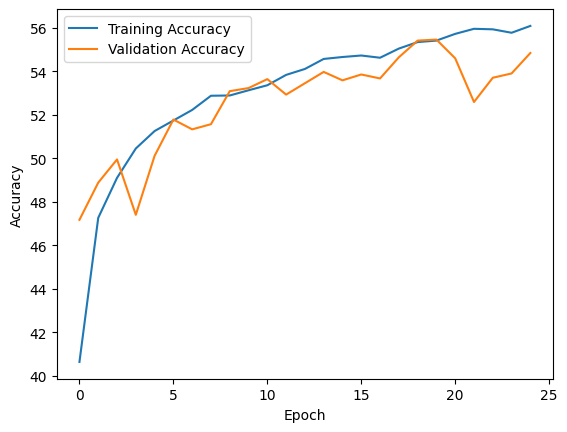

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
    model, trainloader, testloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

Plot confusion matrix


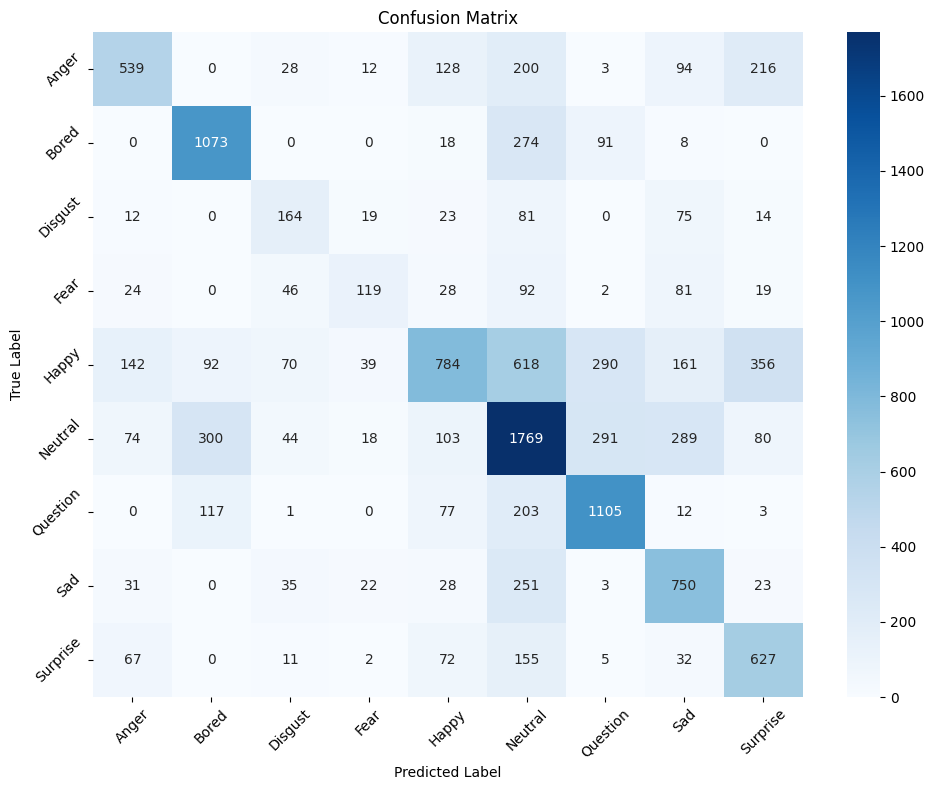

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()


# To use this function, collect predictions and true labels during testing
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)